In [21]:
import sys
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import gc

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold, GroupKFold
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR

from ydf import RandomForestLearner, GradientBoostedTreesLearner
import ydf

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# csvをimportする

In [22]:
train = pd.read_csv(f"../data/train.csv", sep=',')
test = pd.read_csv(f"../data/test.csv", sep=',')
train.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [23]:
extra_data = pd.read_csv(f"../data/training_extra.csv", sep=',')
extra_data.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,500000,Under Armour,Canvas,Small,10.0,Yes,Yes,Tote,Blue,23.882052,114.11068
1,500001,Puma,Polyester,Small,4.0,No,Yes,Backpack,Green,11.869095,129.74972
2,500002,Jansport,Polyester,Small,8.0,Yes,Yes,Tote,Red,8.092302,21.37370
3,500003,Nike,Nylon,Large,7.0,No,No,Messenger,Pink,7.719581,48.09209
4,500004,Nike,Leather,Large,9.0,No,Yes,Tote,Green,22.741826,77.32461


In [24]:
sample_submission = pd.read_csv(f"../data/sample_submission.csv", sep=',')
sample_submission.head()

,id,Price
0,300000,81.411
1,300001,81.411
2,300002,81.411
3,300003,81.411
4,300004,81.411


In [25]:
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"extra_data.shape: {extra_data.shape}")
print(f"sample_submission.shape: {sample_submission.shape}")

train.shape: (300000, 11)
test.shape: (200000, 10)
extra_data.shape: (3694318, 11)
sample_submission.shape: (200000, 2)


In [26]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column                Non-Nul

# カテゴリ特徴量の種類を見る

In [30]:
cat_cols = train.select_dtypes(include=['object', 'category']).columns
print(cat_cols)

Index(['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof',
       'Style', 'Color'],
      dtype='object')


In [28]:
for column in categorical_features:
    print(f"Column: {column}")
    print(train[column].value_counts())
    print("\n")

Column: Brand
Adidas          60077
Under Armour    59992
Nike            57336
Puma            56814
Jansport        56076
Name: Brand, dtype: int64


Column: Material
Polyester    79630
Leather      73416
Nylon        70603
Canvas       68004
Name: Material, dtype: int64


Column: Size
Medium    101906
Large      98643
Small      92856
Name: Size, dtype: int64


Column: Laptop Compartment
Yes    148342
No     144214
Name: Laptop Compartment, dtype: int64


Column: Waterproof
Yes    148077
No     144873
Name: Waterproof, dtype: int64


Column: Style
Messenger    100031
Tote          97438
Backpack      94561
Name: Style, dtype: int64


Column: Color
Pink     51690
Gray     50280
Blue     48097
Red      47219
Green    46386
Black    46378
Name: Color, dtype: int64




# 料金の分布をみる

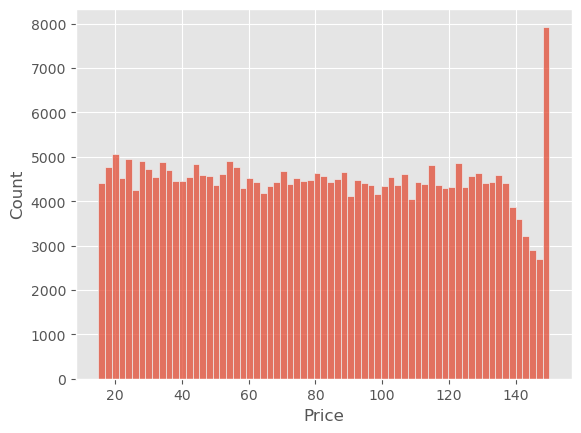

In [29]:
sns.histplot(data=train, x='Price')
plt.show();

## カテゴリデータと料金の箱ひげ図を作成

In [31]:
cat_cols = ["Brand", "Material", "Size", "Laptop Compartment", "Waterproof", "Style", "Color"]

for col in cat_cols:
    train[col] = train[col].fillna('Unknown')
    train[col] = train[col].astype('category')

    test[col] = test[col].fillna('Unknown')
    test[col] = test[col].astype('category')

<Axes: xlabel='Style', ylabel='Price'>

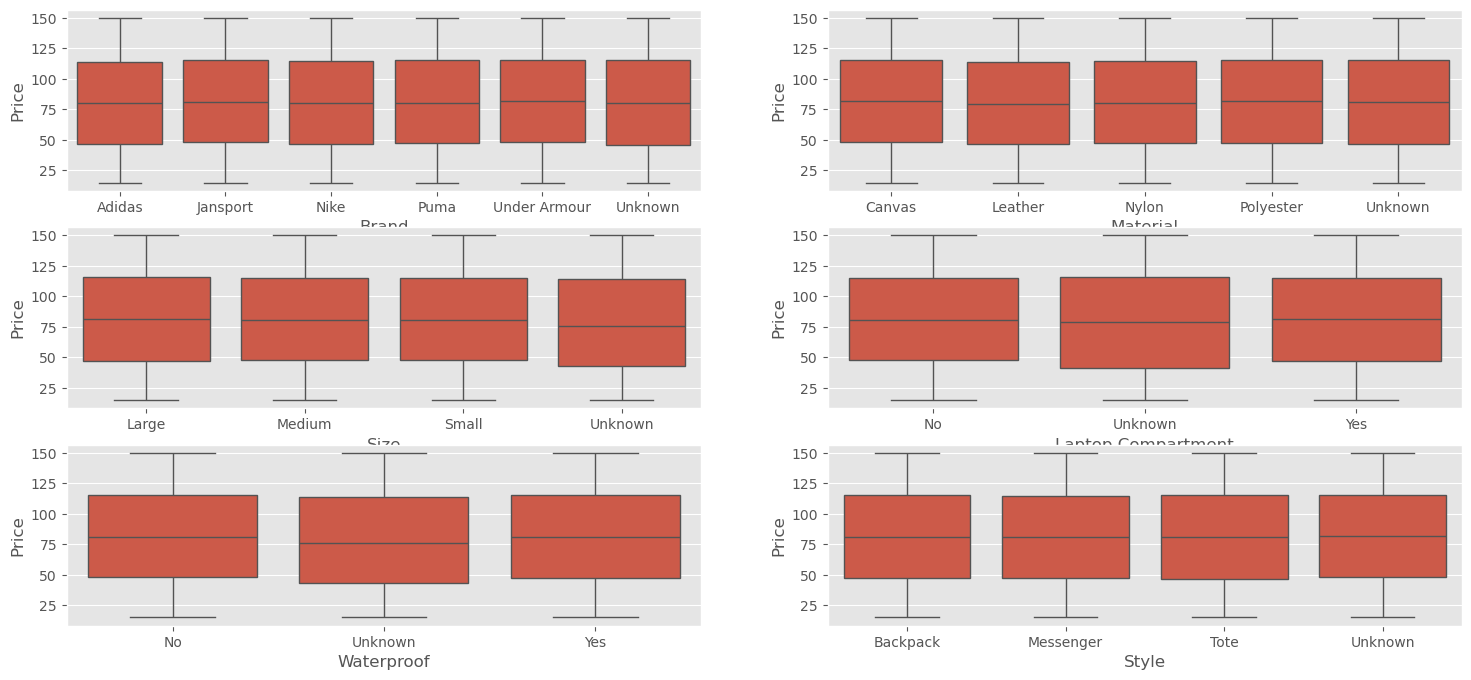

In [48]:
fig, axes = plt.subplots(3, 2, figsize=(18, 8))

sns.boxplot(data=train, x="Brand", y="Price", ax=axes[0,0])
sns.boxplot(data=train, x="Material", y="Price", ax=axes[0,1])
sns.boxplot(data=train, x="Size", y="Price", ax=axes[1,0])
sns.boxplot(data=train, x="Laptop Compartment", y="Price", ax=axes[1,1])
sns.boxplot(data=train, x="Waterproof", y="Price", ax=axes[2,0])
sns.boxplot(data=train, x="Style", y="Price", ax=axes[2,1])

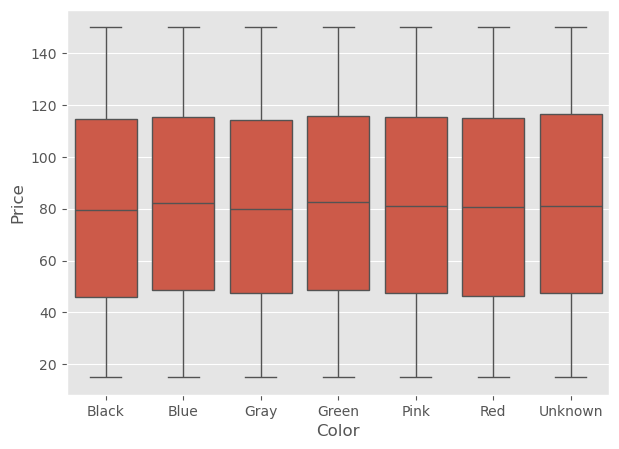

In [46]:
plt.figure(figsize=(7, 5))

sns.boxplot(data=train, x="Color", y="Price");